In [ ]:
import os
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)



u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)


u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)


outputs = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/All-datasets/bowl/stage_train/"
TEST_PATH = "/content/drive/MyDrive/All-datasets/bowl/stage_test/"

In [ ]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [ ]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [ ]:
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'train_ids : {len(train_ids)}')
print(f'test_ids : {len(test_ids)}')

X_train shape: (2, 128, 128, 3)
Y_train shape: (2, 128, 128, 1)
train_ids : 2
test_ids : 2


In [ ]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
        
    Y_train[n] = mask

Resizing training images and masks


100%|██████████| 2/2 [00:11<00:00,  5.70s/it]


In [ ]:

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    
print('Done!')

Resizing test images


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

Done!


In [ ]:
seed = 42
np.random.seed = seed

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)


history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=checkpointer)

Epoch 1/25
1/1 [==============================] - 3s 3s/step - loss: 0.6908 - accuracy: 0.6544 - val_loss: 0.6284 - val_accuracy: 0.8817

Epoch 00001: val_loss improved from inf to 0.62835, saving model to model_for_nuclei.h5
Epoch 2/25
1/1 [==============================] - 0s 294ms/step - loss: 0.6563 - accuracy: 0.8819 - val_loss: 0.4799 - val_accuracy: 0.9057

Epoch 00002: val_loss improved from 0.62835 to 0.47992, saving model to model_for_nuclei.h5
Epoch 3/25
1/1 [==============================] - 0s 303ms/step - loss: 0.4034 - accuracy: 0.9134 - val_loss: 3.3487 - val_accuracy: 0.9252

Epoch 00003: val_loss did not improve from 0.47992
Epoch 4/25
1/1 [==============================] - 0s 297ms/step - loss: 0.9609 - accuracy: 0.9453 - val_loss: 0.7661 - val_accuracy: 0.9252

Epoch 00004: val_loss did not improve from 0.47992
Epoch 5/25
1/1 [==============================] - 0s 307ms/step - loss: 0.3233 - accuracy: 0.9464 - val_loss: 0.4213 - val_accuracy: 0.9258

Epoch 00005: val

In [ ]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 100ms/step


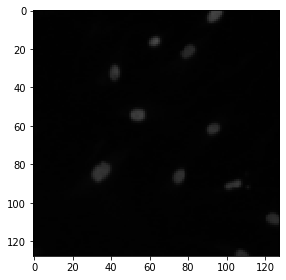

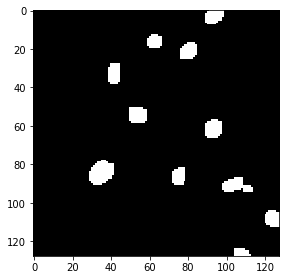

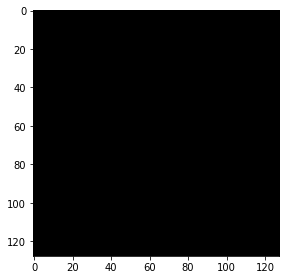

In [ ]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

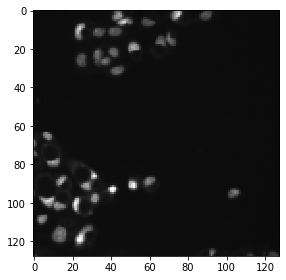

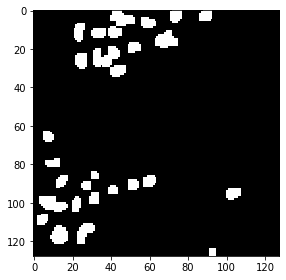

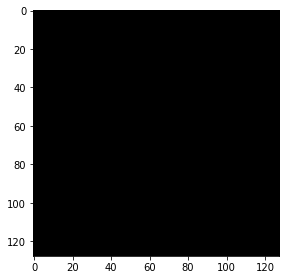

In [ ]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()